## Main for automatic tree cadastre
### by Sabine Zagst

#### License notices

"""
Automatic Tree Cadastre
This program automatically creates a tree cadastre from a point cloud.

Copyright (c) 2022-2023 Sabine Zagst (s.zagst@tum.de)

This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""

#### Import

In [20]:
import numpy as np
import open3d as o3d
from importlib import reload
import laspy

import ground as gr
import cylinder_approach as ca
import imageProcessing_approach as ipa
import run_FME_Workspace as runFME


In [21]:
# TODO: Before using this program you have to set some parameters and define all necessary paths in the next section:
visualize = False
preprocessing_las = False
save_images = True
ground_rastersize = 1.0

pxlsize_binary_img = np.float64(0.025)  # Arcisstrasse [m]
# pxlsize_binary_img = np.float64(0.040)  # Pasinger Klostergarten [m]

# num_peaks influences correctnes and completeness
num_peaks = 10  # Arcisstrasse Sued
# num_peaks = 16  # Arcisstrasse Nord
# num_peaks = 45  # Pasinger Klostergarten


#### Define file paths

In [22]:
# Filepath and filename of point cloud

# filepath = "C:/Users/Sabine/Desktop/Masterarbeit_Code/Data/Arcisstrasse/"
# filename = "pp_arcisNorthThirdRound.pcd"
# filename = "pp_arcisSouthFirstRound.pcd"

filepath = "C:/Users/Sabine/Desktop/Masterarbeit_Code/Data/Arcisstrasse/georeferenziert/"
filename = "pp_arcisSouthFirstRound_geo.las"
# filename = "pp_arcisNorthFirstRound_geo.las"
# TODO: Turn off preprocessing!

# filepath = "C:/Users/Sabine/Desktop/Masterarbeit_Code/Data/Pasing_Klostergarten/Rucksack_Daten/georefed/"
# filename = "2022-10-25-12-06-51_MLS_garden_reg.las"
# TODO: Turn on preprocessing!

# filepath = "C:/Users/Sabine/Desktop/Masterarbeit_Code/Data/p seminar pktwolke/"
# filename = "P-Seminar_PW_bereinigt - CloudSegment.las"


### Read and Preprocessing

In [23]:
print("Read point cloud: " + filename)

if any(ext in filename for ext in [".pcd", ".xyz", ".xyzn", ".xyzrgb", ".pts", ".ply"]):
    cloud_o3d = o3d.io.read_point_cloud(filepath + filename, remove_nan_points=True)
    # supported file types: http://www.open3d.org/docs/latest/tutorial/Basic/file_io.html
    cloud_array = np.asarray(
        cloud_o3d.points
    )  # necessary to access x, y, z - values; output array of float64 with size (numberOfPoints, 3)

    # output for user
    if len(cloud_array) > 0:
        print("Read successful.")
        print(cloud_o3d)
    else:
        print("Point cloud empty.")

elif any(ext in filename for ext in [".las", ".laz"]):
    cloud = laspy.read(filepath + filename)
    points = cloud.points

    if len(cloud) > 0:
        print("Read successful. File header: ")
        print(cloud.header)
        print("Number of points: ")
        print(cloud.header.point_count)
    else:
        print("Point cloud empty.")

    if preprocessing_las:
        cloud_array_i = np.vstack(
            (cloud.x, cloud.y, cloud.z, cloud.intensity)
        ).transpose()
        # Filter intensity 0 and 255
        cloud_array_i = cloud_array_i[cloud_array_i[:, 3] < 255]
        cloud_array_i = cloud_array_i[cloud_array_i[:, 3] > 0]
        cloud_array = cloud_array_i[:, 0:3]
        print(f"Number of points after filtering with intensity: {len(cloud_array)}")
    else:
        cloud_array = np.vstack((cloud.x, cloud.y, cloud.z)).transpose()

    # o3d cloud object
    cloud_o3d = o3d.geometry.PointCloud()
    cloud_o3d.points = o3d.utility.Vector3dVector(cloud_array)

    if preprocessing_las:
        # http://www.open3d.org/docs/release/python_api/open3d.geometry.PointCloud.html
        # Remove duplicated points
        cloud_o3d = cloud_o3d.remove_duplicated_points() # identical coordinates
        print(f"Number of points after removing duplicated points: {len(cloud_o3d.points)}")
        # Remove all points from pcd that have a nan entry or infinite entries
        cloud_o3d = cloud_o3d.remove_non_finite_points()
        print(f"Number of points after removing non-finite points: {len(cloud_o3d.points)}")
        # Statistical outlier removal filter
        # http://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html
        # http://www.open3d.org/docs/0.6.0/python_api/open3d.geometry.statistical_outlier_removal.html
        cloud_o3d, ind = cloud_o3d.remove_statistical_outlier(nb_neighbors=10, std_ratio=2.0)
        cloud_array = np.asarray(cloud_o3d.points)
        print(f"Number of points after SOR filtering: {len(cloud_array)}") 

else:
    print("Unsupported file type.")

print(cloud_array)


Read point cloud: pp_arcisNorthFirstRound_geo.las
Read successful. File header: 
<LasHeader(1.2, <PointFormat(3, 0 bytes of extra dims)>)>
Number of points: 
23146900
[[6.91066006e+05 5.33602750e+06 5.61480581e+02]
 [6.91066030e+05 5.33602750e+06 5.61470453e+02]
 [6.91066001e+05 5.33602744e+06 5.61494254e+02]
 ...
 [6.91097295e+05 5.33610279e+06 5.62887683e+02]
 [6.91097196e+05 5.33610277e+06 5.62841155e+02]
 [6.91097102e+05 5.33610274e+06 5.62794294e+02]]


#### Visualize input point cloud

In [24]:
# Press the H key to print out a complete list of keyboard instructions for the GUI
if visualize:
    o3d.visualization.draw_geometries([cloud_o3d])


#### Write point cloud to file

In [25]:

# o3d.io.write_point_cloud("copy_of_pcd.pcd", cloud_o3d, write_ascii=False)

# outFile = laspy.LasData(cloud.header)
# # extract ground points, and save it to a las file.
# outFile.points = points[ground_array]
# outFile.write("csf_pcd/ground.las")


#### Ground

CSF done.
Number of non-ground points: 14490199
Number of ground points: 8656701
CSF took 75.162s to complete.
 Plot bodenraster_plot.jpg is saved to Images/.


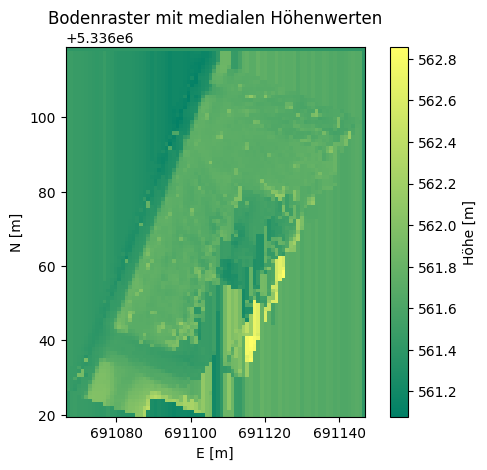

It took 304.677s to get an uniform height level. 
 

In [26]:
reload(gr)

ground_array, nonGround_array, ground_grid = gr.process_ground(
    cloud_array,
    "ground_grid",
    ground_rastersize,
    visualize,
    save_images
)


#### Tree Parameters

In [27]:
# reload(ca)
# nonGround_o3d = o3d.geometry.PointCloud()
# nonGround_o3d.points = o3d.utility.Vector3dVector(nonGround_array)
# dbh = ca.cylinder_approach(nonGround_o3d, visualize=True)
# print(dbh)


In [28]:
reload(ipa)

ipa.imageProcessing_approach(
    nonGround_array, ground_grid, pxlsize_binary_img, np.float64(0.10), num_peaks, save_images, visualize, ground_rastersize
)
# for results see output folder


c:\Users\Sabine\Desktop\Masterarbeit_Code\automatic-tree-cadastre\imageProcessing_approach.py:384: RuntimeWarning: invalid value encountered in cast
  ).astype(np.uint8)


Image grayscale_img.png is successfully saved as file to Images/.
Image grayscale_img_filtered.png is successfully saved as file to Images/.
Image binary_trunk.png is successfully saved as file to Images/.
It took 393.716s to create all three images.
 624 circles detected by circular Hough transform.
Image binary_dbh2.png is successfully saved as file to Images/.
Image circles_dbh.png is successfully saved as file to Images/.
624 circles detected by circular Hough transform.
Image binary_trunk2.png is successfully saved as file to Images/.
Image circles_trunk.png is successfully saved as file to Images/.
Image found_similiarCircles_dbh2.png is successfully saved as file to Images/.
145 similar circles found in circles_dbh and circles_trunk.
It took 96.301s to detect trees.
 Tree number 2 was deleted because the tree height is smaller than the mean crown diameter.
Tree number 3 was deleted because it is too close to another tree (duplicated tree).
Tree number 4 was deleted because it is

#### Run FME Workflow

In [29]:
runFME.run_FME_Workspace()
